# Summer Irrigated Cropping Area (SICA) method

This notebook runs a simplified version of the SICA method. 

### Load packages

In [1]:
import datacube
import scipy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd

from dea_tools.plotting import rgb, display_map, map_shapefile
from dea_tools.spatial import xr_vectorize, xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from skimage.segmentation import quickshift

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='simple_sica')

### Define and display AOI

In [3]:
# Define central coordinates of AOI and buffer values
lat, lon = (-30.0994, 149.5383)
lat_buffer = 0.13
lon_buffer = 0.13

# Combine central coordinates with buffer values 
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Set date range for the analysis
time_range = ('2020-11', '2021-03')

# Display AOI on map 
display_map(x=lon_range, y=lat_range)

### Load data

In [4]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data with at least 50% good data 
ds = load_ard(dc=dc, products=['s2a_ard_granule'], min_gooddata=0.50, **query)

Finding datasets
    s2a_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 7 out of 29 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 7 time steps


### Plot time series of AOI

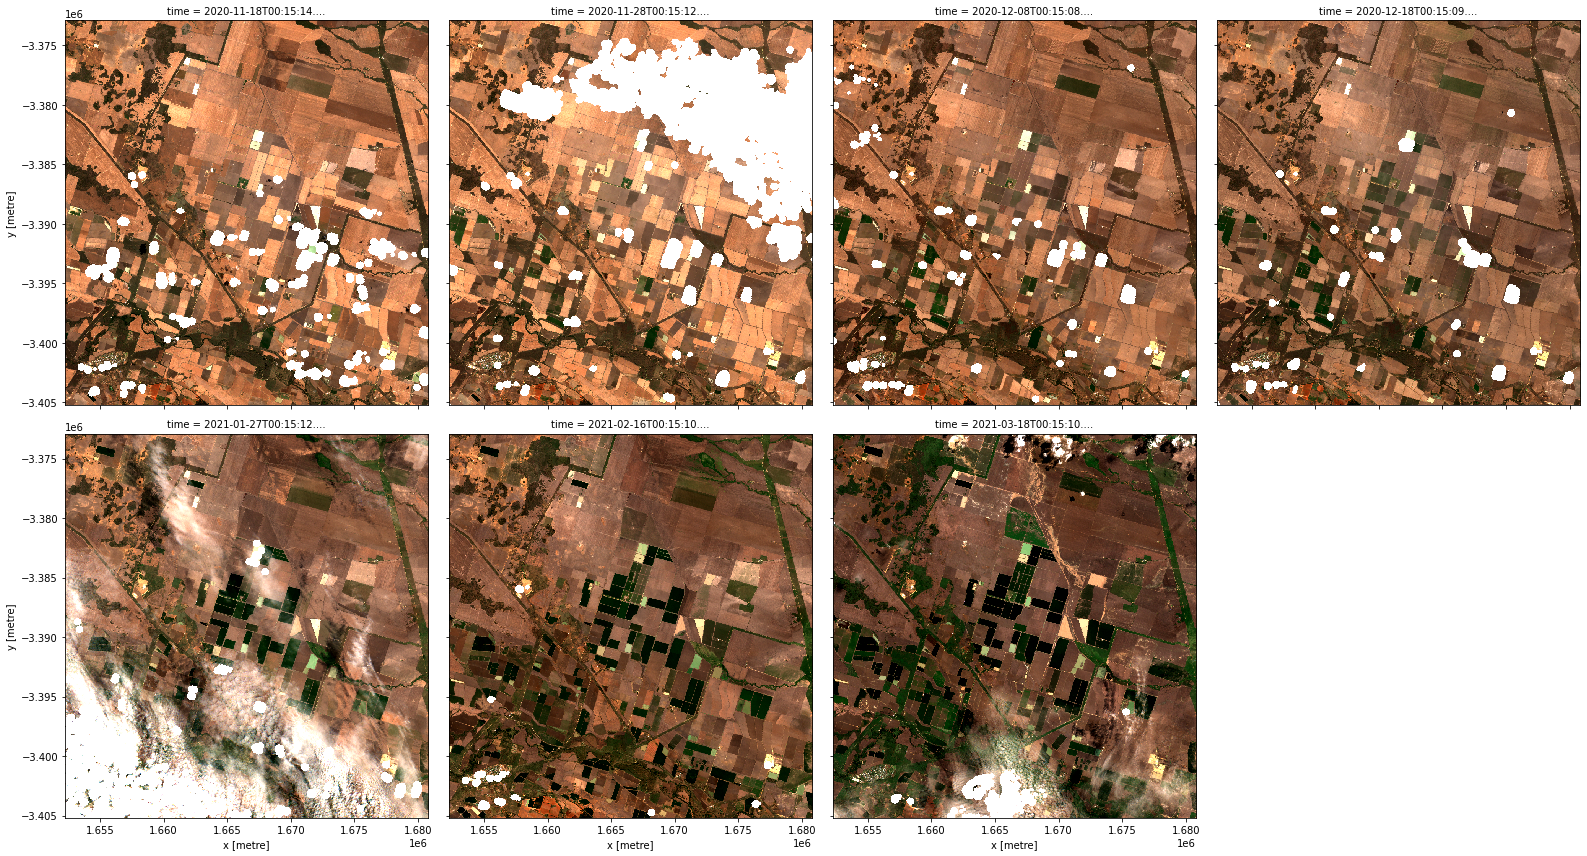

In [5]:
rgb(ds, col="time", col_wrap = 4)

### Calcualte NDVI for each scene

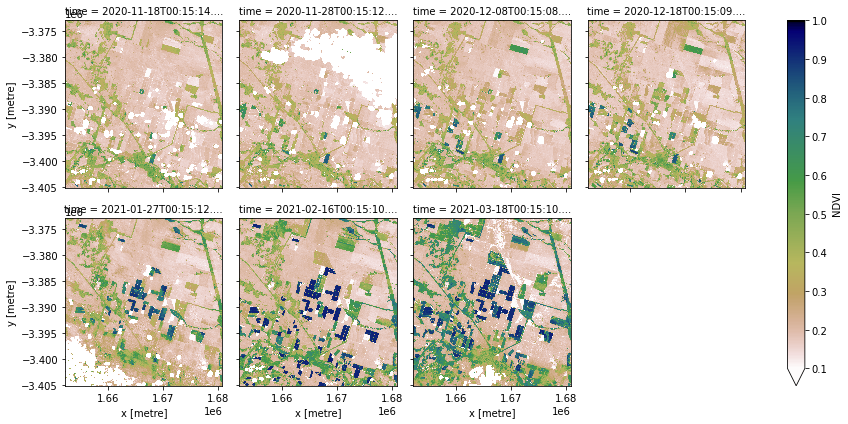

In [6]:
# Calculate NDVI
ndvi = calculate_indices(ds, index='NDVI', collection='ga_s2_1')

# Plot results
ndvi.NDVI.plot(col='time', cmap='gist_earth_r', col_wrap = 4, vmin=0.1, vmax=1.0)

### Generate maximum NDVI composite 

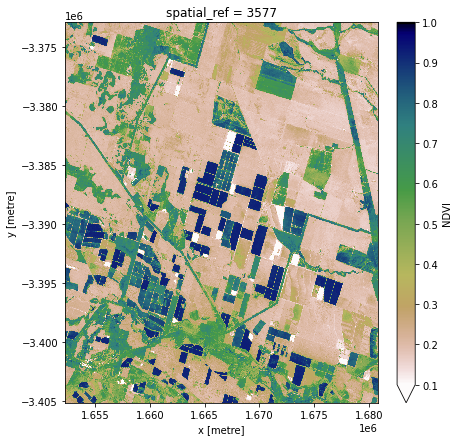

In [7]:
# Generate maximum NDVI composite
max_ndvi = ndvi.max(dim='time', keep_attrs=True)

# View the results
max_ndvi.NDVI.plot(cmap='gist_earth_r', vmin=0.1, vmax=1.0, figsize=(7, 7));

### Run image segmentation 

In [8]:
# Convert our maximum NDVI composite into a numpy.array
input_array = max_ndvi.NDVI.values.astype(np.float64)

In [9]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=5,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0, 
                      sigma=0)

### Calculate zonal statistics 

In [10]:
# Calculate the zonal mean NDVI across the segments
segments_means = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)

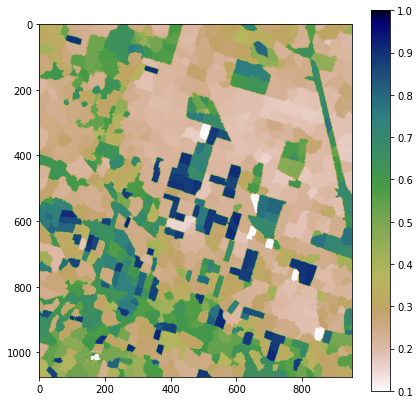

In [11]:
# Plot results
plt.figure(figsize=(7, 7))
plt.imshow(segments_means, cmap='gist_earth_r', vmin=0.1, vmax=1.0)
plt.colorbar(shrink=1)

In [12]:
# Convert numpy.array back to xarray.DataArray
segments_means = xr.DataArray(segments_means, 
             coords=max_ndvi.coords, 
             dims=['y', 'x'], 
             attrs=ndvi.attrs)

### Remove segments where NDVI < 0.8

In [13]:
# Drop zones that have an average threshold of less than 0.8
summer_irrigated_areas = segments_means.where(segments_means > 0.8, drop=True)

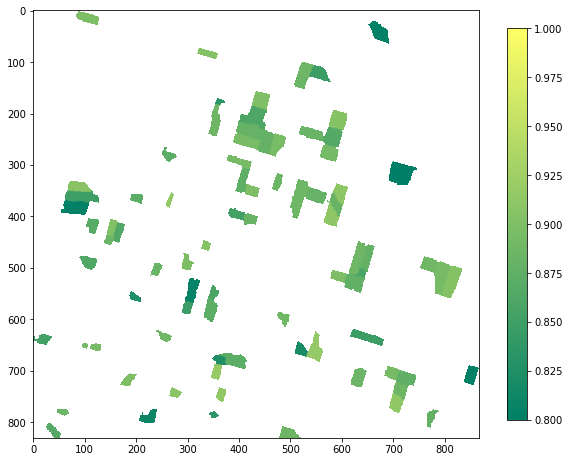

In [14]:
# Plot results 
plt.figure(figsize=(10, 9))
plt.imshow(summer_irrigated_areas, cmap='summer', vmin=0.8, vmax=1.0)
plt.colorbar(shrink=0.8)

### Export as geojson

In [15]:
# Convert to geopandas.GeoDataFrame
gdf = xr_vectorize(summer_irrigated_areas,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=summer_irrigated_areas.values>0)

<AxesSubplot:>

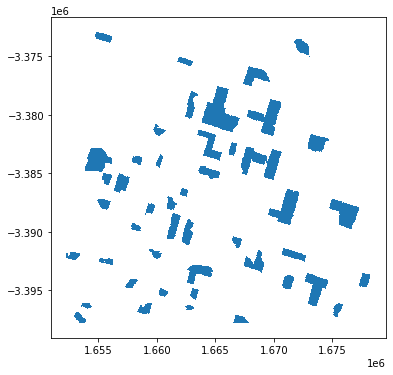

In [16]:
# Plot results 
gdf.plot(figsize=(6, 6))

In [17]:
gdf = xr_vectorize(da=summer_irrigated_areas,
                   crs=ds.crs,
                   mask=summer_irrigated_areas.values>0,
                   export_shp='summer_irrigated_areas.geojson')